In [0]:
import matplotlib.pyplot as plt
import numpy as np
#!pip uninstall viznet -y
#!pip install -U git+https://github.com/GiggleLiu/viznet.git
try:
    import viznet
except:
    !pip install -U git+https://github.com/GiggleLiu/viznet.git
    import viznet
from viznet import NodeBrush, EdgeBrush

def _show():
    plt.axis('off')
    plt.axis('equal')
    plt.show()

# Basic Operations

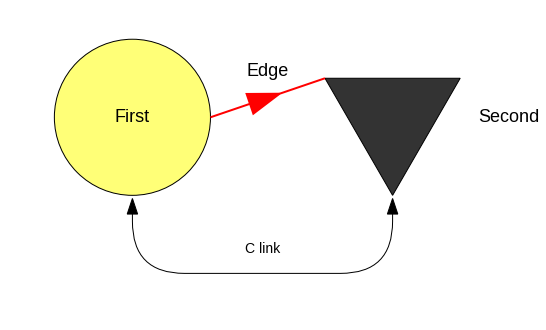

In [33]:
brush1 = NodeBrush('nn.input', size='normal')
brush2 = NodeBrush('tn.tri', size='normal', rotate=np.pi)
edge = EdgeBrush('->-', lw=2, zorder=1000, color='r')

# paint a node at (x=1, y=0)
node1 = brush1 >> (1,0)
node2 = brush2 >> (2,0)
# add texts to nodes
node1.text('First', 'center', fontsize=18)
node2.text('Second', 'right', fontsize=18)

# connect two nodes
e12 = edge >> (node1, node2)
e12.text('Edge', 'top', fontsize=18)

# use C link
clink = viznet.CLinkBrush('<->', offsets=(-0.3,), roundness=0.2)
cl = clink >> (node1.pin('bottom'), node2.pin(-np.pi/2.))
cl.text('C link', 'top', fontsize=14)

_show()

# Connection and Pinning
`edge >> (node1, node2)` generates a **natural connection**. i.e. finding face center or vertex that connect two objects most efficiently.

If natural connection if not what you need, you may use `pin`, which returns a special `Pin` node object that subclassing `viznet.EdgeNode` and `np.ndarray` at the same time.

`pin` method can use both a node's binding box using ('top'|'bottom'|left'|'right') or its vertices using **angle**s to find the `Pin`.

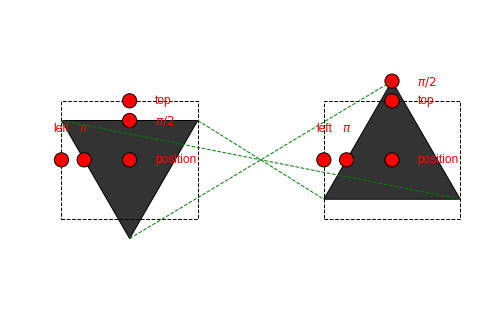

In [34]:
dot = NodeBrush('qc.C', color='r', size='tiny')

def make_box(node):
    box = NodeBrush('box', size=(node.width/2., node.height/2.), ls='--', color='none')
    box >> node.position
    
    # points
    (dot >> node.position).text('position', 'right', color='r')
    (dot >> node.pin('top')).text('top', 'right', color='r')
    (dot >> node.pin(np.pi/2.)).text('$\pi/2$', 'right', color='r')
    (dot >> node.pin('left')).text('left', 'top', color='r')
    (dot >> node.pin(np.pi)).text('$\pi$', 'top', color='r')
    
brush2.rotate = np.pi
n1 = brush2 >> (1, 0)
make_box(n1)

# rotate brush2 to normal angle
brush2.rotate = 0
n2 = brush2 >> (2, 0)
make_box(n2)

dashline = EdgeBrush('.', color='g')
for angle in [np.pi/2, np.pi*7/6, -np.pi/6]:
    dashline >> (n1.pin(np.pi+angle), n2.pin(angle))
_show()

# Grid System
Grid system make you can define a grid, and use saocaozuo like `rectangle >> grid[i,j]` and `brush >> grid[2:4, 4:7]` to plot on a predefine grid. Notice here, the brush must be **rectangular**!

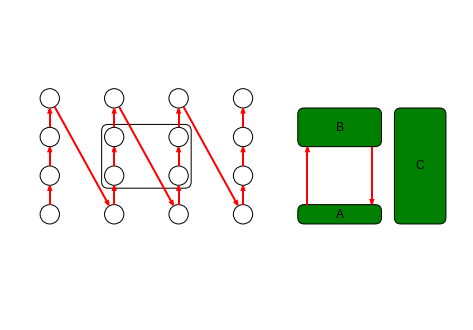

In [35]:
grid = viznet.Grid((2.0, 1.2), offset=(2,2))
brush = NodeBrush('basic')
edge = EdgeBrush('->', lw=2., color='r')
box = NodeBrush('box', roundness=0.2, size='large')

# define an mpo
mpo = NodeBrush('box', color='g', roundness=0.2)

brushes = []

for i in range(4):
    for j in range(4):
        brushes.append(brush >> grid[i, j])
for i in range(15):
    edge >> (brushes[i], brushes[i+1])
box >> grid[1:2, 1:2]

# generate two mpos
A = mpo >> grid[4:5, 0:0]; A.text('A')
B = mpo >> grid[4:5, 2:2.5]; B.text('B')
# if you don't like grid, you can do use slices directly.
C = mpo >> (slice(13,14), slice(2, 5)); C.text('C')

# connect left legs.
edge >> (A.pin('top', align = grid[4, 0]), B.pin('bottom', align = grid[4, 0]))
edge >> (B.pin('bottom', align = grid[5, 0]), A.pin('top', align = grid[5, 0]))
_show()

# Cluster Wise Operations
Cluster operations is quite useful when coping neural networks.

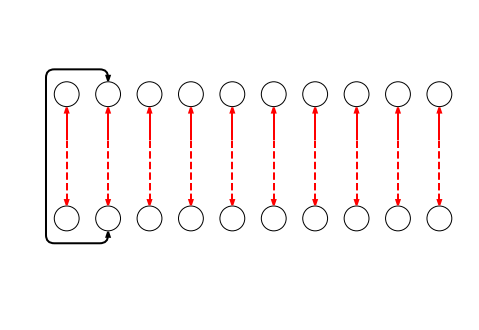

In [36]:
# we have two sequences of nodes
seq1 = [brush >> (i,0) for i in range(10)]
seq2 = [brush >> (i,3) for i in range(10)]

# connect them one by one use a fancier edge
edge2 = viznet.EdgeBrush('<..->', lw=2, zorder=1000, color='r')
viznet.connect121(seq1, seq2, edge2)

# and clink type of edges
clink.lw = 2
clink.offsets = (0.3, 1.5)
clink >> (seq1[1].pin('bottom'), seq2[1].pin('top'))

_show()

Here, the edge is a combination of characters in `"-.=<>"`, the number of `"-.="` decide the relative length.

Also, we have all to all connections

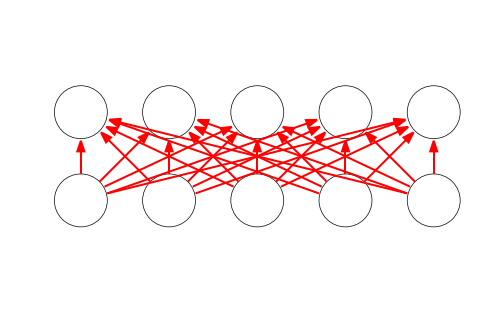

In [7]:
# we have two sequences of nodes
seq1 = [brush >> (i,0) for i in range(5)]
seq2 = [brush >> (i,1) for i in range(5)]

# make a all to all connect
viznet.connecta2a(seq1, seq2, edge)

_show()

# Quantum Circuit Handler
First, let's see some predefined themes

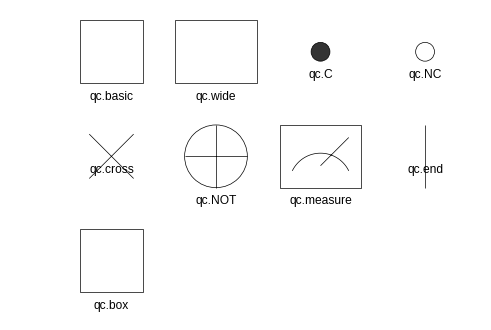

In [8]:
i = 0
for kind in viznet.theme.NODE_THEME_DICT.keys():
    if kind[:3] == 'qc.':
        brush = NodeBrush(kind)
        node = brush >> (i%4, -(i//4))
        node.text(kind, 'bottom')
        i += 1
_show()


# then we define some brushes
basic = NodeBrush('qc.basic')
C = NodeBrush('qc.C')
NC = NodeBrush('qc.NC', size='tiny')
NOT = NodeBrush('qc.NOT', size='small')
END = NodeBrush('qc.end')
cross = NodeBrush('qc.cross')
M = NodeBrush('qc.measure')

# define a box, and make it wider, this box size can change during plot
box = NodeBrush('qc.box'); box.size = (0.5, 0.3)

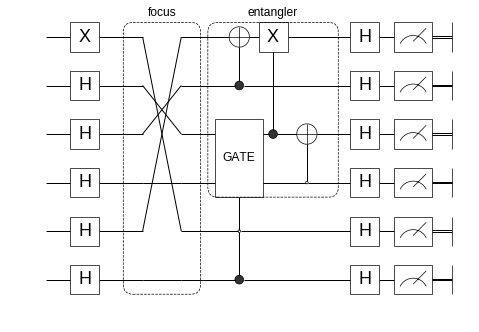

In [9]:
# To begin, define a circuit handler
num_bit = 6
handler = viznet.QuantumCircuit(num_bit=num_bit)

# right shift the current x by 0.8 and place an X gate at 0-th line.
handler.x += 0.8
handler.gate(basic, 0, 'X')

for i in range(1, num_bit):
    handler.gate(basic, i, 'H')
    
# handler.block returns a context, circuit defined in this block will be enclosed with a dashed box.
# this context then returns a list of `Node`.
handler.x += 1.2
with handler.block(slice(0, num_bit-1), pad_x=0.1) as b:
    # focus will move focused lines to top, can be viewed as permute.
    handler.focus([4, 2, 1, 3])
b[0].text('focus', 'top')

# entangler block
handler.x += 1.2
with handler.block(slice(0, 3)) as b:
    handler.gate((C, NOT), (1, 0))
    # notice the height of this box is changed to fit the line.
    handler.gate((C, NC, box), (5, 4, slice(2,3)), text=['','','GATE'], fontsize=12)
    handler.x += 0.7
    handler.gate((C, basic), (2, 0), ['','X'])
    handler.x += 0.7
    handler.gate((NC, NOT), (3, 2))
b[0].text('entangler', 'top')

handler.x += 1.2
for i in range(num_bit):
    handler.gate(basic, i, 'H')
    
# put a normal ending, measure and become a classical bit.
handler.x += 1
for i in range(num_bit):
    handler.gate(M, i)
handler.edge.style = '='
handler.x += 0.8
for i in range(num_bit):
    handler.gate(END, i)
_show()

# Play with global settings
Some settings like edgecolor of a node can be found only under global setting.

{'lw': 1, 'edgecolor': 'k', 'inner_lw': 1, 'inner_edgecolor': 'k', 'inner_facecolor': 'none'}


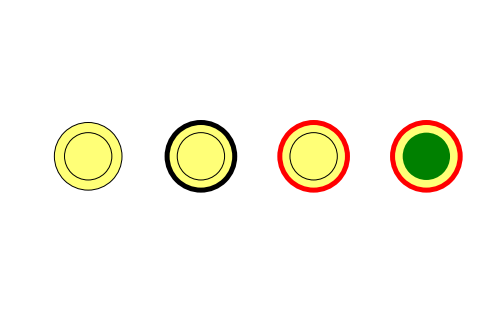

In [29]:
node = NodeBrush('nn.backfed')
print(viznet.setting.node_setting)
node >> (0, 0)

viznet.setting.node_setting['lw'] = 5
node >> (1, 0)

viznet.setting.node_setting['edgecolor'] = 'r'
node >> (2, 0)

viznet.setting.node_setting['inner_facecolor'] = 'g'
viznet.setting.node_setting['inner_lw'] = 0
node >> (3, 0)
_show()

# restore
viznet.setting.node_setting['edgecolor'] = 'k'
viznet.setting.node_setting['inner_facecolor'] = 'none'
viznet.setting.node_setting['inner_lw'] = 1
viznet.setting.node_setting['lw'] = 1

# Define New Nodes
Using a path you can define a node.
We have some predefined shapes under `viznet.shapes`, however, you can define a new one by specifying the paths.

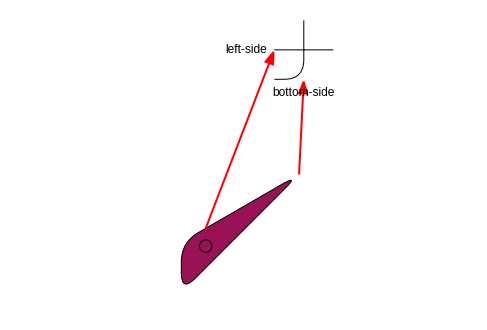

In [37]:
magic_angle = 37.5/180*np.pi
magic_vec = np.array([np.cos(magic_angle), np.sin(magic_angle)])

path = np.array([(0,0), (-1, -1), (-1, -1./np.sqrt(3))])*4 + 4*magic_vec
# node theme can be define as (color, geometry, and inner-geometry) tuple. polygon requires 'path' property.
geo = NodeBrush(('#981255', 'polygon', 'dot'), roundness=0.2, props={'path':path})

# another flexible definition of node is lines, it take multiple paths.
paths = [[(-1, -1), (0, -1), (0, 1)], [(-1,0), (1, 0)]]
lines = NodeBrush(('#981255', 'lines', 'none'), roundness=0.2, props={'paths':paths})

g = geo >> (0, 0)
l = lines >> (1,2)

tip = g.pin(magic_angle)
edge >> (tip, l)

# when using pin, you can also specify an float as the angle, it will search pin points at the surface.
# however, an angle pi/2 is not equivalent to 'top', 'top' will search pin points on its containing `box` while angle will search the `surface` of a node.
edge >> (g.pin(np.pi/2.), l.pin('left'))
l.text('left-side', 'left')
l.text('bottom-side', 'bottom')
_show()


# Thanks
Flowers!

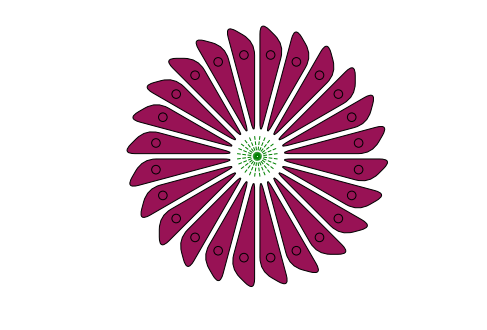

In [31]:
dangle = 15./180*np.pi
from viznet.utils import rotate

geo_list = []
ngo = 360//15
for i in range(ngo):
    geo.rotate = dangle*i
    ig = geo >> - rotate(1.5*magic_vec, geo.rotate)
    geo_list.append(ig.pin(magic_angle + geo.rotate))
viznet.connect121(geo_list[:ngo//2], geo_list[ngo//2:], dashline)
_show()